<h3>輸入原影像，經過壓縮轉換，再由轉換壓縮碼，還原成類原圖</h3>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
from glob import glob
import numpy

In [3]:
import cv2

In [4]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [5]:
import keras
from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib import cm

<h3>環境設置</h3>

In [7]:
image_path = 'images/objects/train'
max_dim = (256, 256, 3)
enhance_flag = False

kernel = numpy.array([[-1, -1, -1], [-1, 11, -1], [-1, -1, -1]])

alpha = 0.6 # Contrast control (1.0-3.0)
beta = 2 # Brightness control (0-100)

In [8]:
def read_image_file(my_image_file, enhanced=False):
    global max_dim, kernel, alpha, beta
    
    _fish_image = cv2.imread(my_image_file, cv2.COLOR_BGR2RGB)
    
    if enhanced:
        _fish_image = cv2.filter2D(_fish_image, -1, kernel)
        _fish_image = cv2.convertScaleAbs(_fish_image.copy(), alpha=alpha, beta=beta)

    _fish_image = cv2.resize(_fish_image.copy(), max_dim[:2])
    
    return _fish_image

In [9]:
def show_image(my_image):
    global max_dim
    
    _my_image = numpy.reshape(my_image, max_dim)
    
    fig, ax = plt.subplots(dpi=120)
    
    ax.imshow(my_image)
    ax.axis('off')
    
    plt.show()

<h3>載入魚影像檔</h3>

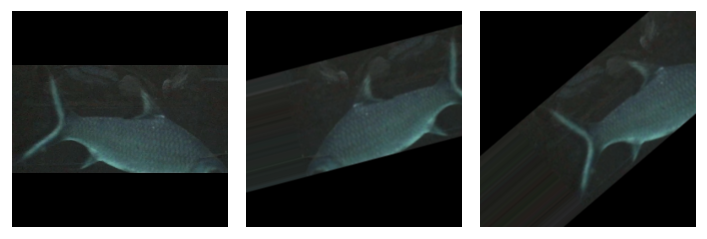

In [10]:
datagen = ImageDataGenerator(rotation_range=45,
                             width_shift_range=[0.1, 0.2],
                             height_shift_range=[0.1, 0.2],
                             horizontal_flip=True)

_fish_image = read_image_file('%s/F000079-00001.jpg' % image_path, enhance_flag)

fig, ax = plt.subplots(dpi=120, ncols=3)

ax[0].imshow(_fish_image)
ax[0].axis('off')

_fish_img_data = img_to_array(_fish_image)    
_fish_img_data = numpy.expand_dims(_fish_img_data, 0)

it = datagen.flow(_fish_img_data, batch_size=1)

for i in range(1, 3):
    _batch = it.next()
    _generated_image = _batch[0].astype('uint8')
            
    ax[i].imshow(_generated_image, cmap='gray', interpolation='bicubic')
    ax[i].axis('off')
    
plt.tight_layout()
plt.show()

In [11]:
def load_data(image_path, train_ratio=0.8, enhanced=False):
    global max_dim

    datagen = ImageDataGenerator(rotation_range=45,
                                 width_shift_range=[0.1, 0.2],
                                 height_shift_range=[0.1, 0.2],
                                 horizontal_flip=True
    )
    
    image_files = glob('%s/F*.jpg' % image_path)

    my_images = []

    for image_file in image_files:
        _image_file = image_file.replace('\\', '/')
        
        _fish_image = read_image_file(_image_file, enhanced)
        
        my_images.append(numpy.reshape(_fish_image, max_dim))

        _fish_img_data = img_to_array(_fish_image)    
        _fish_img_data = numpy.expand_dims(_fish_img_data, 0)
        
        it = datagen.flow(_fish_img_data, batch_size=1)

        for i in range(10):
            _batch = it.next()
            _generated_image = _batch[0].astype('uint8')
            
            my_images.append(numpy.reshape(_generated_image, max_dim))

    my_images = numpy.array(my_images)
    numpy.random.shuffle(my_images)
    
    pos = int(my_images.shape[0] * train_ratio)
    return my_images[:pos], my_images[pos:]

In [12]:
x_train, x_test = load_data(image_path, 0.8, enhance_flag)

In [13]:
x_train.shape, x_test.shape

((4488, 256, 256, 3), (1122, 256, 256, 3))

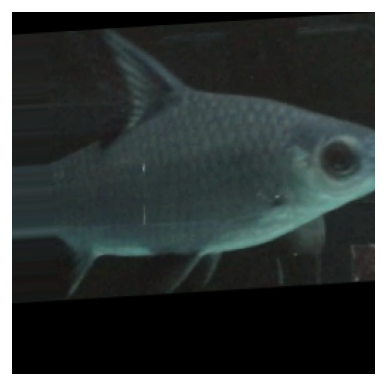

In [14]:
show_image(x_train[numpy.random.randint(len(x_train))])

<h3>將 0 ~ 255 值域，轉換為: 0 ~ 1</h3>

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

<h3>參數設置</h3>
<p>$$壓縮率: \frac {{256}*{256}={65536}}{64} = 1024$$</p>

<h3>建立模型</h3>

In [16]:
input_img = keras.Input(shape=max_dim, name='input')

In [17]:
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_128')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_256')(x)

In [18]:
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_64')(x)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_128')(x)

In [19]:
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2D_32')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same', name='latent')(x)

In [20]:
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', name='Conv2DT_32')(encoded)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_64')(x)

In [21]:
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', name='Conv2DT_64')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_128')(x)

In [22]:
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', name='Conv2DT_128')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_256')(x)

In [23]:
decoded = layers.Conv2D(max_dim[-1], (3, 3), padding='same', name='output')(x)

In [24]:
autoencoder = keras.Model(input_img, decoded)

In [25]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D_128 (Conv2D)          (None, 256, 256, 128)     3584      
_________________________________________________________________
MaxPooling2D_256 (MaxPooling (None, 128, 128, 128)     0         
_________________________________________________________________
Conv2D_64 (Conv2D)           (None, 128, 128, 64)      73792     
_________________________________________________________________
MaxPooling2D_128 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
Conv2D_32 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
latent (MaxPooling2D)        (None, 32, 32, 32)       

In [26]:
autoencoder.compile(optimizer='adam', loss='mse')  # binary_crossentropy

<h3>訓練模型</h3>

In [27]:
checkpointer = ModelCheckpoint(
    filepath='CNN-C-0-128-64-32.hdf5', 
    monitor="val_loss", verbose=1, 
    save_best_only=True, mode='auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [28]:
num_of_epoch = 512
num_of_batch_size = 8

In [29]:
score = autoencoder.fit(x_train, x_train,
                        epochs=num_of_epoch,
                        batch_size=num_of_batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[checkpointer, earlyStop]
                       )

Epoch 1/512
561/561 [==============================] - ETA: 0s - loss: 7.2785e-04
Epoch 00001: val_loss improved from inf to 0.00021, saving model to CNN-C-0-128-64-32.hdf5
561/561 [==============================] - 24s 42ms/step - loss: 7.2785e-04 - val_loss: 2.1388e-04
Epoch 2/512
561/561 [==============================] - ETA: 0s - loss: 1.6278e-04
Epoch 00002: val_loss improved from 0.00021 to 0.00014, saving model to CNN-C-0-128-64-32.hdf5
561/561 [==============================] - 23s 40ms/step - loss: 1.6278e-04 - val_loss: 1.3685e-04
Epoch 3/512
561/561 [==============================] - ETA: 0s - loss: 1.6053e-04
Epoch 00003: val_loss did not improve from 0.00014
561/561 [==============================] - 23s 40ms/step - loss: 1.6053e-04 - val_loss: 1.5478e-04
Epoch 4/512
561/561 [==============================] - ETA: 0s - loss: 1.2814e-04
Epoch 00004: val_loss improved from 0.00014 to 0.00011, saving model to CNN-C-0-128-64-32.hdf5
561/561 [==============================] - 

561/561 [==============================] - ETA: 0s - loss: 6.7050e-05
Epoch 00032: val_loss did not improve from 0.00006
561/561 [==============================] - 22s 40ms/step - loss: 6.7050e-05 - val_loss: 6.2984e-05
Epoch 33/512
561/561 [==============================] - ETA: 0s - loss: 6.6204e-05
Epoch 00033: val_loss did not improve from 0.00006
561/561 [==============================] - 22s 40ms/step - loss: 6.6204e-05 - val_loss: 7.5447e-05
Epoch 34/512
561/561 [==============================] - ETA: 0s - loss: 6.7780e-05
Epoch 00034: val_loss did not improve from 0.00006
561/561 [==============================] - 22s 40ms/step - loss: 6.7780e-05 - val_loss: 7.0500e-05
Epoch 35/512
561/561 [==============================] - ETA: 0s - loss: 7.2457e-05
Epoch 00035: val_loss did not improve from 0.00006
561/561 [==============================] - 22s 40ms/step - loss: 7.2457e-05 - val_loss: 6.3296e-05
Epoch 36/512
561/561 [==============================] - ETA: 0s - loss: 6.3993e-0

561/561 [==============================] - ETA: 0s - loss: 5.6419e-05
Epoch 00065: val_loss did not improve from 0.00005
561/561 [==============================] - 22s 40ms/step - loss: 5.6419e-05 - val_loss: 5.3616e-05
Epoch 66/512
561/561 [==============================] - ETA: 0s - loss: 5.5149e-05
Epoch 00066: val_loss improved from 0.00005 to 0.00005, saving model to CNN-C-0-128-64-32.hdf5
561/561 [==============================] - 22s 40ms/step - loss: 5.5149e-05 - val_loss: 5.0342e-05
Epoch 67/512
561/561 [==============================] - ETA: 0s - loss: 5.5351e-05
Epoch 00067: val_loss did not improve from 0.00005
561/561 [==============================] - 22s 40ms/step - loss: 5.5351e-05 - val_loss: 5.1341e-05
Epoch 68/512
561/561 [==============================] - ETA: 0s - loss: 5.4946e-05
Epoch 00068: val_loss improved from 0.00005 to 0.00005, saving model to CNN-C-0-128-64-32.hdf5
561/561 [==============================] - 22s 40ms/step - loss: 5.4946e-05 - val_loss: 5.03

Epoch 99/512
561/561 [==============================] - ETA: 0s - loss: 5.1532e-05
Epoch 00099: val_loss improved from 0.00005 to 0.00005, saving model to CNN-C-0-128-64-32.hdf5
561/561 [==============================] - 22s 40ms/step - loss: 5.1532e-05 - val_loss: 4.6601e-05
Epoch 100/512
561/561 [==============================] - ETA: 0s - loss: 5.1202e-05
Epoch 00100: val_loss did not improve from 0.00005
561/561 [==============================] - 22s 40ms/step - loss: 5.1202e-05 - val_loss: 4.6811e-05
Epoch 101/512
561/561 [==============================] - ETA: 0s - loss: 5.0598e-05
Epoch 00101: val_loss did not improve from 0.00005
561/561 [==============================] - 22s 40ms/step - loss: 5.0598e-05 - val_loss: 4.8190e-05
Epoch 102/512
561/561 [==============================] - ETA: 0s - loss: 5.0927e-05
Epoch 00102: val_loss did not improve from 0.00005
561/561 [==============================] - 22s 40ms/step - loss: 5.0927e-05 - val_loss: 5.0808e-05
Epoch 103/512
561/561

Epoch 133/512
561/561 [==============================] - ETA: 0s - loss: 4.8326e-05
Epoch 00133: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.8326e-05 - val_loss: 4.5270e-05
Epoch 134/512
561/561 [==============================] - ETA: 0s - loss: 4.8985e-05
Epoch 00134: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.8985e-05 - val_loss: 4.5911e-05
Epoch 135/512
561/561 [==============================] - ETA: 0s - loss: 4.8851e-05
Epoch 00135: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.8851e-05 - val_loss: 8.8628e-05
Epoch 136/512
561/561 [==============================] - ETA: 0s - loss: 5.0500e-05
Epoch 00136: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 5.0500e-05 - val_loss: 4.4617e-05
Epoch 137/512
561/561 [==============================] - ETA: 0s

Epoch 168/512
561/561 [==============================] - ETA: 0s - loss: 4.7275e-05
Epoch 00168: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.7275e-05 - val_loss: 4.5293e-05
Epoch 169/512
561/561 [==============================] - ETA: 0s - loss: 4.8211e-05
Epoch 00169: val_loss improved from 0.00004 to 0.00004, saving model to CNN-C-0-128-64-32.hdf5
561/561 [==============================] - 22s 40ms/step - loss: 4.8211e-05 - val_loss: 4.3529e-05
Epoch 170/512
561/561 [==============================] - ETA: 0s - loss: 4.8500e-05
Epoch 00170: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.8500e-05 - val_loss: 4.5366e-05
Epoch 171/512
561/561 [==============================] - ETA: 0s - loss: 4.8236e-05
Epoch 00171: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.8236e-05 - val_loss: 6.5826e-05
Epoch 172/512
561/56

561/561 [==============================] - ETA: 0s - loss: 4.8886e-05
Epoch 00202: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.8886e-05 - val_loss: 4.3054e-05
Epoch 203/512
561/561 [==============================] - ETA: 0s - loss: 4.7325e-05
Epoch 00203: val_loss did not improve from 0.00004
561/561 [==============================] - 23s 41ms/step - loss: 4.7325e-05 - val_loss: 4.3061e-05
Epoch 204/512
561/561 [==============================] - ETA: 0s - loss: 4.5405e-05
Epoch 00204: val_loss did not improve from 0.00004
561/561 [==============================] - 23s 41ms/step - loss: 4.5405e-05 - val_loss: 4.3316e-05
Epoch 205/512
561/561 [==============================] - ETA: 0s - loss: 5.1260e-05
Epoch 00205: val_loss did not improve from 0.00004
561/561 [==============================] - 23s 40ms/step - loss: 5.1260e-05 - val_loss: 4.3620e-05
Epoch 206/512
561/561 [==============================] - ETA: 0s - loss: 4.477

Epoch 237/512
561/561 [==============================] - ETA: 0s - loss: 4.8980e-05
Epoch 00237: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.8980e-05 - val_loss: 4.2212e-05
Epoch 238/512
561/561 [==============================] - ETA: 0s - loss: 4.5536e-05
Epoch 00238: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.5536e-05 - val_loss: 4.2313e-05
Epoch 239/512
561/561 [==============================] - ETA: 0s - loss: 4.5636e-05
Epoch 00239: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.5636e-05 - val_loss: 4.9300e-05
Epoch 240/512
561/561 [==============================] - ETA: 0s - loss: 4.6060e-05
Epoch 00240: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.6060e-05 - val_loss: 4.6830e-05
Epoch 241/512
561/561 [==============================] - ETA: 0s

Epoch 272/512
561/561 [==============================] - ETA: 0s - loss: 4.6141e-05
Epoch 00272: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.6141e-05 - val_loss: 4.5630e-05
Epoch 273/512
561/561 [==============================] - ETA: 0s - loss: 4.3127e-05
Epoch 00273: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.3127e-05 - val_loss: 4.2085e-05
Epoch 274/512
561/561 [==============================] - ETA: 0s - loss: 5.8816e-05
Epoch 00274: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 5.8816e-05 - val_loss: 4.7993e-05
Epoch 275/512
561/561 [==============================] - ETA: 0s - loss: 4.7566e-05
Epoch 00275: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.7566e-05 - val_loss: 4.3801e-05
Epoch 276/512
561/561 [==============================] - ETA: 0s

Epoch 307/512
561/561 [==============================] - ETA: 0s - loss: 4.7639e-05
Epoch 00307: val_loss improved from 0.00004 to 0.00004, saving model to CNN-C-0-128-64-32.hdf5
561/561 [==============================] - 22s 40ms/step - loss: 4.7639e-05 - val_loss: 4.0588e-05
Epoch 308/512
561/561 [==============================] - ETA: 0s - loss: 4.3521e-05
Epoch 00308: val_loss improved from 0.00004 to 0.00004, saving model to CNN-C-0-128-64-32.hdf5
561/561 [==============================] - 22s 40ms/step - loss: 4.3521e-05 - val_loss: 4.0576e-05
Epoch 309/512
561/561 [==============================] - ETA: 0s - loss: 4.3807e-05
Epoch 00309: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.3807e-05 - val_loss: 4.2078e-05
Epoch 310/512
561/561 [==============================] - ETA: 0s - loss: 4.4345e-05
Epoch 00310: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.4345e-05

561/561 [==============================] - ETA: 0s - loss: 4.5346e-05
Epoch 00341: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.5346e-05 - val_loss: 4.1468e-05
Epoch 342/512
561/561 [==============================] - ETA: 0s - loss: 4.4004e-05
Epoch 00342: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.4004e-05 - val_loss: 4.1282e-05
Epoch 343/512
561/561 [==============================] - ETA: 0s - loss: 4.3870e-05
Epoch 00343: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.3870e-05 - val_loss: 4.0602e-05
Epoch 344/512
561/561 [==============================] - ETA: 0s - loss: 4.4596e-05
Epoch 00344: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.4596e-05 - val_loss: 4.0110e-05
Epoch 345/512
561/561 [==============================] - ETA: 0s - loss: 4.883

Epoch 376/512
561/561 [==============================] - ETA: 0s - loss: 4.2877e-05
Epoch 00376: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.2877e-05 - val_loss: 4.2607e-05
Epoch 377/512
561/561 [==============================] - ETA: 0s - loss: 4.5163e-05
Epoch 00377: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.5163e-05 - val_loss: 4.0284e-05
Epoch 378/512
561/561 [==============================] - ETA: 0s - loss: 4.3937e-05
Epoch 00378: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.3937e-05 - val_loss: 4.4319e-05
Epoch 379/512
561/561 [==============================] - ETA: 0s - loss: 4.5470e-05
Epoch 00379: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.5470e-05 - val_loss: 4.1109e-05
Epoch 380/512
561/561 [==============================] - ETA: 0s

Epoch 411/512
561/561 [==============================] - ETA: 0s - loss: 4.5281e-05
Epoch 00411: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.5281e-05 - val_loss: 3.9802e-05
Epoch 412/512
561/561 [==============================] - ETA: 0s - loss: 5.0293e-05
Epoch 00412: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 5.0293e-05 - val_loss: 4.1080e-05
Epoch 413/512
561/561 [==============================] - ETA: 0s - loss: 4.4477e-05
Epoch 00413: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.4477e-05 - val_loss: 4.0767e-05
Epoch 414/512
561/561 [==============================] - ETA: 0s - loss: 4.5752e-05
Epoch 00414: val_loss did not improve from 0.00004
561/561 [==============================] - 22s 40ms/step - loss: 4.5752e-05 - val_loss: 4.1296e-05
Epoch 415/512
561/561 [==============================] - ETA: 0s

<h3>模型訓練績效</h3>

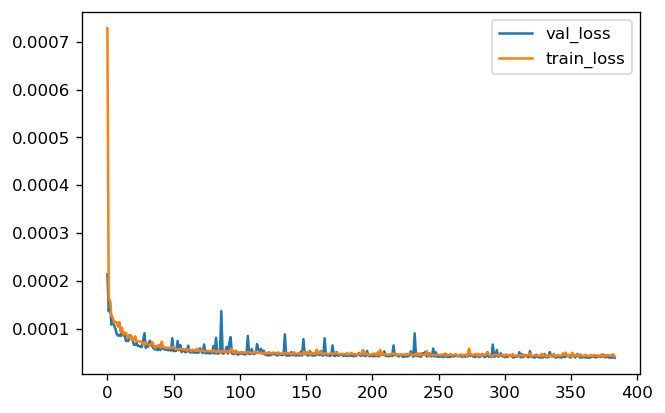

In [30]:
best_iteration = numpy.argmin(score.history['val_loss']) + 1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

fig, ax = plt.subplots(dpi=120)

ax.plot(val_scores, label='val_loss')
ax.plot(train_scores, label='train_loss')

plt.legend(loc='upper right')
plt.show()

<h3>產生假圖</h3>

In [31]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent").output)

encoded_imgs = encoder.predict(x_test)
print(encoded_imgs.shape)

encoded_imgs = encoded_imgs.reshape((len(encoded_imgs), max_dim[0]//2, max_dim[1]//2, 2))

(1122, 32, 32, 32)


In [32]:
decoded_imgs = autoencoder.predict(x_test)

In [33]:
x_test.shape, encoded_imgs.shape, decoded_imgs.shape

((1122, 256, 256, 3), (1122, 128, 128, 2), (1122, 256, 256, 3))

<h3>隨機顯示抽象圖與假圖</h3>

In [34]:
i = numpy.random.randint(0, x_test.shape[0], 1)[0]
i = 1021

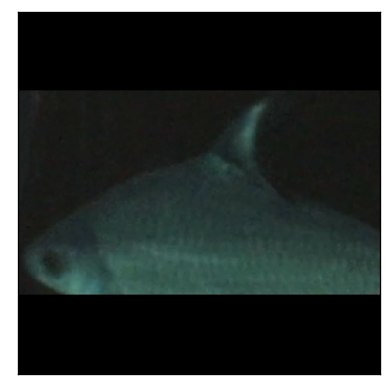

In [35]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(x_test[i].reshape(max_dim))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


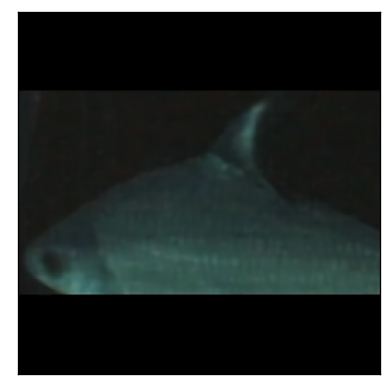

In [36]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

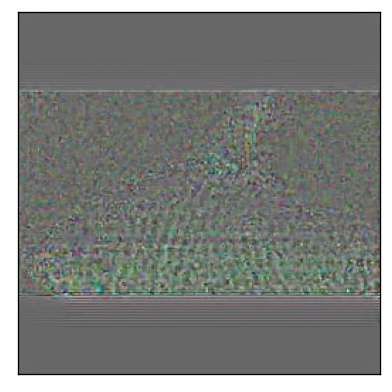

In [37]:
fig, ax = plt.subplots(dpi=120)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax.imshow(diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

<h3>顯示原圖與假圖</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


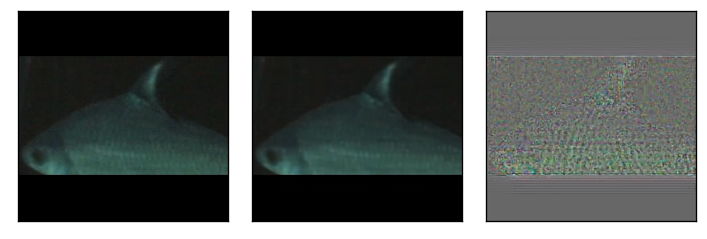

In [38]:
fig, (ax0, ax2, ax3) = plt.subplots(dpi=120, ncols=3)

ax0.imshow(x_test[i].reshape(max_dim), cmap=plt.cm.binary)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax2.imshow(decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax3.imshow(diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [39]:
def benchmark(my_diff_image):
    diff = 0.0
    
    for i in range(3):
        diff += numpy.sum(numpy.square(diff_image[i]))
        
    return diff**0.5

In [40]:
benchmark(diff_image)

0.03298846401095652

In [41]:
faint_image_files = glob('%s/F*.jpg' % 'images/objects/faint')

In [42]:
my_faint_images = []

for image_file in faint_image_files[:24]:
    _image_file = image_file.replace('\\', '/')

    _fish_image = read_image_file(_image_file, enhance_flag)

    my_faint_images.append(numpy.reshape(_fish_image, max_dim))

my_faint_images = numpy.array(my_faint_images)

In [43]:
my_faint_images = my_faint_images.astype('float32') / 255.
my_faint_images = numpy.reshape(my_faint_images, (my_faint_images.shape[0],) + max_dim)

In [44]:
my_faint_images.shape

(24, 256, 256, 3)

<h3>產生假圖</h3>

In [45]:
encoding_dim = (32, 32, 64)

In [49]:
faint_encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent").output)

faint_encoded_imgs = faint_encoder.predict(my_faint_images)
faint_encoded_imgs = faint_encoded_imgs.reshape((len(faint_encoded_imgs), max_dim[0]//2, max_dim[1]//2, 2))

In [50]:
faint_decoded_imgs = autoencoder.predict(my_faint_images)

<h3>顯示原圖與假圖</h3>

In [51]:
def find_faint_file_pos(my_image_id=None):
    pos = -1
    
    if my_image_id is None:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
    else:
        for j in range(len(faint_image_files)):
            image_file = faint_image_files[j]
            if my_image_id in image_file:
                pos = j
                break
            
    if pos == -1:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
        
    return pos

In [52]:
i = find_faint_file_pos()
i = 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


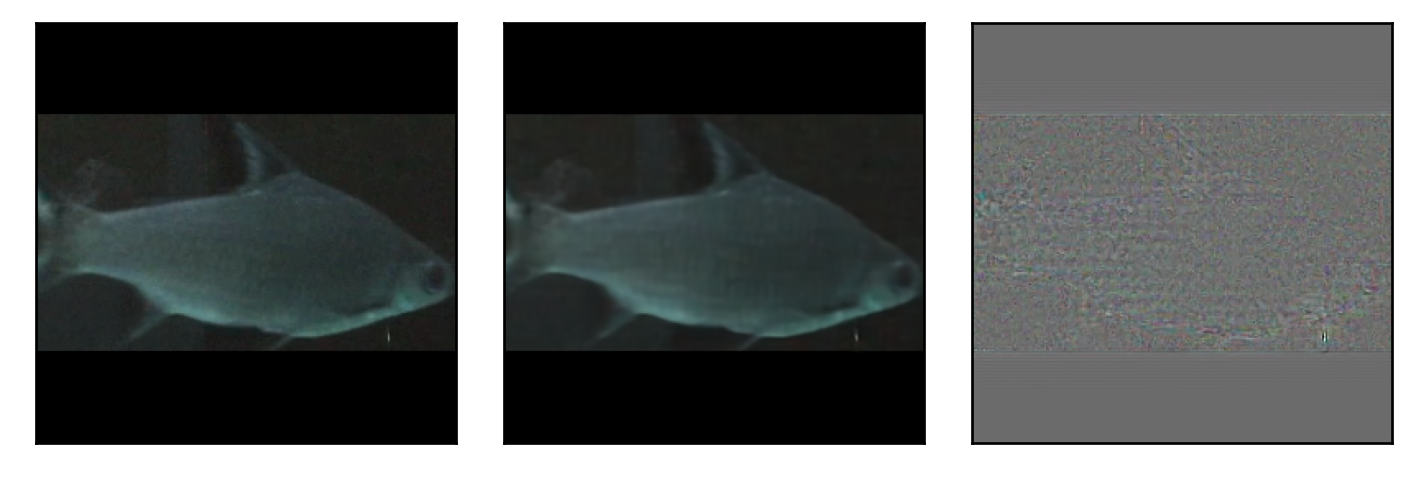

In [53]:
fig, (ax0, ax1, ax2) = plt.subplots(dpi=240, ncols=3)

ax0.imshow(my_faint_images[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1.imshow(faint_decoded_imgs[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

faint_diff_image = my_faint_images[i] - faint_decoded_imgs[i]
faint_diff_image_min = faint_diff_image.min()
faint_diff_image_max = faint_diff_image.max()
faint_diff_image_val = (faint_diff_image - faint_diff_image_min) / (faint_diff_image_max - faint_diff_image_min)

ax2.imshow(faint_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [54]:
benchmark(faint_diff_image)

0.03298846401095652